In [1]:
!pip install datasets
!pip install -U transformers

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.4/491.4 kB 10.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 14.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 11.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 12.1 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2:
      Successfully uninstalled fsspec-2025.3.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-cupti-cu12==12.4.127; platform_system =

In [2]:
from google.colab import drive
drive.mount('/content/drive')

MessageError: Error: credential propagation was unsuccessful

In [ ]:
import torch
import torch.optim as optim
from torch.utils.data import DataLoader
from transformers import (
    BertForSequenceClassification,
    BertTokenizer,
    AutoTokenizer,
    DataCollatorForLanguageModeling,
    DistilBertConfig,
    DataCollatorWithPadding,
    TrainingArguments,
    Trainer
)
from datasets import load_dataset



# Distillation (directly using sequence classification task)
The cell below does distillation between Bert and Small Bert on the IMDB dataset. It does not use masked language modelling. It directly distills on the sequence classification task.

In [ ]:


import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torch.optim as opt
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from datasets import load_dataset
from tqdm import tqdm

# Config
TEACHER_MODEL = "bert-base-uncased"
STUDENT_MODEL = "prajjwal1/bert-small"
BATCH_SIZE = 8
LR = 5e-5
EPOCHS = 3
MAX_LEN = 256
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

# Load IMDb dataset
dataset = load_dataset("imdb")
tokenizer = AutoTokenizer.from_pretrained(TEACHER_MODEL)


def tokenize(example):
    return tokenizer(example["text"], truncation=True, padding="max_length", max_length=MAX_LEN)


tokenized = dataset.map(tokenize, batched=True)
tokenized.set_format(type="torch", columns=[
                     "input_ids", "attention_mask", "label"])
train_loader = DataLoader(
    tokenized["train"], batch_size=BATCH_SIZE, shuffle=True)

# Load teacher and student
teacher = AutoModelForSequenceClassification.from_pretrained(
    TEACHER_MODEL, num_labels=2).to(DEVICE)
student = AutoModelForSequenceClassification.from_pretrained(
    STUDENT_MODEL, num_labels=2).to(DEVICE)
teacher.eval()

optimizer = opt.AdamW(student.parameters(), lr=LR)

# Distillation loss


def distillation_loss(student_logits, teacher_logits, labels, alpha=0.5, T=2.0):
    loss_ce = F.cross_entropy(student_logits, labels)
    loss_kl = F.kl_div(
        F.log_softmax(student_logits / T, dim=-1),
        F.softmax(teacher_logits / T, dim=-1),
        reduction="batchmean"
    ) * (T ** 2)
    return alpha * loss_ce + (1 - alpha) * loss_kl


# Training loop
for epoch in range(EPOCHS):
    student.train()
    total_loss = 0
    for batch in tqdm(train_loader, desc=f"Epoch {epoch+1}"):
        batch = {k: v.to(DEVICE) for k, v in batch.items()}

        with torch.no_grad():
            teacher_outputs = teacher(
                input_ids=batch["input_ids"], attention_mask=batch["attention_mask"])
            teacher_logits = teacher_outputs.logits

        student_outputs = student(
            input_ids=batch["input_ids"], attention_mask=batch["attention_mask"])
        student_logits = student_outputs.logits

        loss = distillation_loss(
            student_logits, teacher_logits, batch["label"])

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    avg_loss = total_loss / len(train_loader)
    print(f"Epoch {epoch+1} | Loss: {avg_loss:.4f}")

# Save the student model and tokenizer
student.save_pretrained("distilled-bert-small-imdb")
tokenizer.save_pretrained("distilled-bert-small-imdb")


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/7.81k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/21.0M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/20.5M [00:00<?, ?B/s]

unsupervised-00000-of-00001.parquet:   0%|          | 0.00/42.0M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating unsupervised split:   0%|          | 0/50000 [00:00<?, ? examples/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Map:   0%|          | 0/25000 [00:00<?, ? examples/s]

Map:   0%|          | 0/25000 [00:00<?, ? examples/s]

Map:   0%|          | 0/50000 [00:00<?, ? examples/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


config.json:   0%|          | 0.00/286 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/116M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at prajjwal1/bert-small and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Epoch 1:   0%|          | 0/3125 [00:00<?, ?it/s]

model.safetensors:   0%|          | 0.00/116M [00:00<?, ?B/s]

Epoch 1: 100%|██████████| 3125/3125 [09:23<00:00,  5.55it/s]


Epoch 1 | Loss: 0.2877


Epoch 2: 100%|██████████| 3125/3125 [09:25<00:00,  5.53it/s]


Epoch 2 | Loss: 0.2651


Epoch 3: 100%|██████████| 3125/3125 [09:26<00:00,  5.52it/s]


Epoch 3 | Loss: 0.2516


('distilled-bert-small-imdb/tokenizer_config.json',
 'distilled-bert-small-imdb/special_tokens_map.json',
 'distilled-bert-small-imdb/vocab.txt',
 'distilled-bert-small-imdb/added_tokens.json',
 'distilled-bert-small-imdb/tokenizer.json')

# Distillation using Masked Language Modelling

In [ ]:
import torch
from torch.utils.data import DataLoader
from transformers import (
    AutoTokenizer,
    AutoModelForMaskedLM,
    DataCollatorForLanguageModeling,
    AutoModelForSequenceClassification,
)
import torch.optim as opt
from datasets import load_dataset
from tqdm import tqdm
import torch.nn.functional as F


In [ ]:
# Config
TEACHER_MODEL = "bert-base-uncased"
# STUDENT_MODEL = "prajjwal1/bert-small"
STUDENT_MODEL = "distilbert-base-uncased"
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
BATCH_SIZE = 8
LR = 5e-5
EPOCHS = 3
MAX_LEN = 128
MLM_PROB = 0.15

In [ ]:
# Load dataset
dataset = load_dataset("wikitext", "wikitext-2-raw-v1", split="train")
tokenizer = AutoTokenizer.from_pretrained(TEACHER_MODEL)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/10.5k [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/733k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/6.36M [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/657k [00:00<?, ?B/s]

Generating test split:   0%|          | 0/4358 [00:00<?, ? examples/s]

Generating train split:   0%|          | 0/36718 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/3760 [00:00<?, ? examples/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [ ]:
def tokenize_function(examples):
    return tokenizer(examples["text"], truncation=True, padding="max_length", max_length=MAX_LEN)

tokenized_dataset = dataset.map(tokenize_function, batched=True, remove_columns=["text"])
tokenized_dataset.set_format(type="torch", columns=["input_ids", "attention_mask"])

# Data collator will mask tokens for us
data_collator = DataCollatorForLanguageModeling(tokenizer=tokenizer, mlm=True, mlm_probability=MLM_PROB)
dataloader = DataLoader(tokenized_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=data_collator)

Map:   0%|          | 0/36718 [00:00<?, ? examples/s]

In [ ]:
# Load teacher and student
teacher = AutoModelForMaskedLM.from_pretrained(TEACHER_MODEL).to(DEVICE)
student = AutoModelForMaskedLM.from_pretrained(STUDENT_MODEL).to(DEVICE)
teacher.eval()


Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForMaskedLM: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

BertForMaskedLM(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwi

In [3]:
def copy_every_other_layer(student, teacher):
    """
    Copy every other teacher layer into the student.
    Assumes student has half as many encoder layers as teacher.
    """
    teacher_layers = teacher.bert.encoder.layer
    student_layers = student.distilbert.transformer.layer

    # Copy every other teacher layer into student
    for i, layer in enumerate(student_layers):
        teacher_layer = teacher_layers[i * 2]
        layer.load_state_dict(teacher_layer.state_dict(), strict=False)

copy_every_other_layer(student, teacher)

NameError: name 'student' is not defined

In [ ]:
print(type(student))


<class 'transformers.models.distilbert.modeling_distilbert.DistilBertForMaskedLM'>


In [4]:
from torch.nn import CosineEmbeddingLoss

# Optional: distillation via KL divergence
def distill_loss(student_logits,
                 teacher_logits,
                 student_hidden,
                 teacher_hidden,
                 labels,
                 temperature=2.0,
                 alpha=0.5,
                 beta=0.5,
                 gamma=1.0):

    cosine_loss_fn = CosineEmbeddingLoss()

    # Only compute loss on masked tokens
    mask = labels != -100
    if mask.sum() == 0:
      print("mask sum is 0")
      return torch.tensor(0.0, device=student_logits.device, requires_grad=True)

    #### Masked LM Loss ####
    ce_loss = F.cross_entropy(student_logits.view(-1, student_logits.size(-1)), labels.view(-1), ignore_index=-100)

    student_logits = torch.clamp(student_logits, -1e4, 1e4)
    teacher_logits = torch.clamp(teacher_logits, -1e4, 1e4)

    # KL divergence between softened predictions
    student_probs = F.log_softmax(student_logits / temperature, dim=-1)
    teacher_probs = F.softmax(teacher_logits / temperature, dim=-1)

    kl_loss = F.kl_div(
        student_probs,
        teacher_probs,
        reduction="batchmean"
    ) * (temperature ** 2)

    # Cosine embedding loss on hidden states
    # Cosine embedding loss between intermediate hidden states
    losses = []
    teacher_layers = teacher_hidden[1::2]  # take every 2nd layer starting from index 1
    student_layers = student_hidden[1:]    # skip the student input embedding layer

    for t, s in zip(teacher_layers, student_layers):
        # Flatten hidden state in vectors of HIDDEN_STATE_SIZE for every token
        # in the batch (B, SEQ_LEN, HIDDEN_STATE_SIZE) -> (B x SEQ_LEN, HIDDEN_STATE_SIZE)
        t_flat = t.reshape(-1, t.size(-1))
        s_flat = s.reshape(-1, s.size(-1))

        # Create a tensor of ones (B x SEQ_LEN) as the target cosine similarity
        # between teacher and student hidden states
        target = torch.ones(t_flat.size(0)).to(t.device)
        losses.append(cosine_loss_fn(s_flat, t_flat, target))

    cos_loss = torch.stack(losses).mean()

    return alpha * ce_loss + beta * kl_loss + gamma * cos_loss

In [ ]:
optimizer = opt.AdamW(student.parameters(), lr=LR)

In [ ]:
for epoch in range(EPOCHS):
    student.train()
    total_loss = 0
    for batch in tqdm(dataloader, desc=f"Epoch {epoch+1}"):
        input_ids = batch["input_ids"].to(DEVICE)
        attention_mask = batch["attention_mask"].to(DEVICE)
        labels = batch["labels"].to(DEVICE)

        with torch.no_grad():
            teacher_outputs = teacher(
                input_ids=input_ids,
                attention_mask=attention_mask,
                output_hidden_states=True
            )
            teacher_logits = teacher_outputs.logits
            teacher_hidden_states = teacher_outputs.hidden_states

        student_outputs = student(
            input_ids=input_ids,
            attention_mask=attention_mask,
            output_hidden_states=True
        )
        student_logits = student_outputs.logits
        student_hidden_states = student_outputs.hidden_states
        loss = distill_loss(student_logits, teacher_logits,
                            student_hidden_states, teacher_hidden_states,
                            labels,
                            temperature=2.0, alpha=0.5, beta=0.5, gamma=1.0)

        if torch.isnan(loss) or torch.isinf(loss):
            print("Skipping batch due to NaN/Inf loss")
            continue

        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(student.parameters(), max_norm=1.0)
        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / len(dataloader)
    print(f"Epoch {epoch+1} | Loss: {avg_loss:.4f}")



student.save_pretrained("distilled-bert-small-wikitext")
tokenizer.save_pretrained("distilled-bert-small-wikitext")

save_path = "/content/drive/MyDrive/CS4782FinalProject/artifacts/imdb/distilled-bert-small-wikitext"

student.save_pretrained(save_path)
tokenizer.save_pretrained(save_path)

Epoch 1:  79%|███████▊  | 3613/4590 [14:08<03:15,  5.01it/s]

mask sum is 0


Epoch 1:  79%|███████▉  | 3639/4590 [14:14<03:07,  5.07it/s]

mask sum is 0


Epoch 1:  99%|█████████▉| 4544/4590 [17:48<00:09,  5.00it/s]

mask sum is 0


Epoch 1: 100%|██████████| 4590/4590 [17:59<00:00,  4.25it/s]


Epoch 1 | Loss: 36.5160


Epoch 2:  96%|█████████▌| 4411/4590 [17:24<00:35,  5.08it/s]

mask sum is 0


Epoch 2: 100%|██████████| 4590/4590 [18:07<00:00,  4.22it/s]


Epoch 2 | Loss: 32.3810


Epoch 3:  12%|█▏        | 568/4590 [02:14<13:34,  4.94it/s]

mask sum is 0


Epoch 3:  23%|██▎       | 1062/4590 [04:10<11:47,  4.99it/s]

mask sum is 0


Epoch 3:  30%|███       | 1389/4590 [05:27<10:42,  4.98it/s]

mask sum is 0


Epoch 3:  34%|███▎      | 1541/4590 [06:03<10:00,  5.07it/s]

mask sum is 0


Epoch 3:  44%|████▍     | 2022/4590 [07:57<08:22,  5.11it/s]

mask sum is 0


Epoch 3:  76%|███████▋  | 3510/4590 [13:49<03:33,  5.07it/s]

mask sum is 0


Epoch 3:  95%|█████████▍| 4344/4590 [17:06<00:49,  4.98it/s]

mask sum is 0


Epoch 3: 100%|██████████| 4590/4590 [18:05<00:00,  4.23it/s]


Epoch 3 | Loss: 31.0600


('/content/drive/MyDrive/CS4782FinalProject/artifacts/imdb/distilled-bert-small-wikitext/tokenizer_config.json',
 '/content/drive/MyDrive/CS4782FinalProject/artifacts/imdb/distilled-bert-small-wikitext/special_tokens_map.json',
 '/content/drive/MyDrive/CS4782FinalProject/artifacts/imdb/distilled-bert-small-wikitext/vocab.txt',
 '/content/drive/MyDrive/CS4782FinalProject/artifacts/imdb/distilled-bert-small-wikitext/added_tokens.json',
 '/content/drive/MyDrive/CS4782FinalProject/artifacts/imdb/distilled-bert-small-wikitext/tokenizer.json')

# Finetune for IMDB sequence classification



In [ ]:
MODEL_PATH = "/content/drive/MyDrive/CS4782FinalProject/artifacts/imdb/distilled-bert-small-wikitext"
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
BATCH_SIZE = 16
EPOCHS = 3
LR = 2e-5

In [ ]:
imdb = load_dataset("imdb")

model_path="/content/drive/MyDrive/CS4782FinalProject/artifacts/imdb/distilled-bert-small-wikitext"
tokenizer = AutoTokenizer.from_pretrained(model_path,local_files_only=True)

def preprocess(example):
    return tokenizer(example["text"], truncation=True, padding="max_length", max_length=256)

encoded_imdb = imdb.map(preprocess, batched=True)
encoded_imdb.set_format(type="torch", columns=["input_ids", "attention_mask", "label"])

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/7.81k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/21.0M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/20.5M [00:00<?, ?B/s]

unsupervised-00000-of-00001.parquet:   0%|          | 0.00/42.0M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating unsupervised split:   0%|          | 0/50000 [00:00<?, ? examples/s]

Map:   0%|          | 0/25000 [00:00<?, ? examples/s]

Map:   0%|          | 0/25000 [00:00<?, ? examples/s]

Map:   0%|          | 0/50000 [00:00<?, ? examples/s]

In [ ]:
data_collator = DataCollatorWithPadding(tokenizer)
train_loader = DataLoader(encoded_imdb["train"], shuffle=True, batch_size=BATCH_SIZE, collate_fn=data_collator)
test_loader = DataLoader(encoded_imdb["test"], batch_size=BATCH_SIZE, collate_fn=data_collator)


**Load the distilled student model and add a classification head to it.**

In [ ]:
from transformers import AutoModelForSequenceClassification
model = AutoModelForSequenceClassification.from_pretrained(MODEL_PATH, num_labels=2).to(DEVICE)


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at /content/drive/MyDrive/CS4782FinalProject/artifacts/imdb/distilled-bert-small-wikitext and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
training_args = TrainingArguments(
    output_dir="./results",
    eval_strategy="epoch",
    learning_rate=LR,
    per_device_train_batch_size=BATCH_SIZE,
    per_device_eval_batch_size=BATCH_SIZE,
    num_train_epochs=EPOCHS,
    weight_decay=0.01,
    save_strategy="epoch",
    logging_dir="./logs",
    logging_steps=100,
    report_to="none"
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=encoded_imdb["train"],
    eval_dataset=encoded_imdb["test"],
    tokenizer=tokenizer,
    data_collator=data_collator,
)

trainer.train()

<ipython-input-18-45a8a5004f82>:15: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss
1,0.254200,0.252246
2,0.168400,0.281097
3,0.125200,0.349982


TrainOutput(global_step=4689, training_loss=0.1915666384340019, metrics={'train_runtime': 2079.8597, 'train_samples_per_second': 36.06, 'train_steps_per_second': 2.254, 'total_flos': 4967527449600000.0, 'train_loss': 0.1915666384340019, 'epoch': 3.0})

In [ ]:
save_path = "/content/drive/MyDrive/CS4782FinalProject/artifacts/imdb/finetuned-distilled-imdb"
model.save_pretrained(save_path)

NameError: name 'model' is not defined

In [ ]:

# Load teacher model with classification head
teacher_model = AutoModelForSequenceClassification.from_pretrained(
    "bert-base-uncased",
    num_labels=2
).to(DEVICE)

teacher_training_args = TrainingArguments(
    output_dir="./results-teacher",
    eval_strategy="epoch",
    learning_rate=LR,
    per_device_train_batch_size=BATCH_SIZE,
    per_device_eval_batch_size=BATCH_SIZE,
    num_train_epochs=EPOCHS,
    weight_decay=0.01,
    save_strategy="epoch",
    logging_dir="./logs-teacher",
    logging_steps=100,
    report_to="none"
)

teacher_trainer = Trainer(
    model=teacher_model,
    args=teacher_training_args,
    train_dataset=encoded_imdb["train"],
    eval_dataset=encoded_imdb["test"],
    tokenizer=tokenizer,  # Use student tokenizer since it was already applied to data
    data_collator=data_collator,
)

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
<ipython-input-14-1ce8cbb86703>:21: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  teacher_trainer = Trainer(


In [ ]:
# === Train the teacher ===
teacher_trainer.train()

# === Evaluate the teacher ===
teacher_trainer.evaluate()

Epoch,Training Loss,Validation Loss
1,0.232300,0.223978
2,0.148300,0.278025
3,0.079800,0.326050


{'eval_loss': 0.32605043053627014,
 'eval_runtime': 361.6872,
 'eval_samples_per_second': 69.121,
 'eval_steps_per_second': 4.321,
 'epoch': 3.0}

In [ ]:
teacher_finetuned_path = "/content/drive/MyDrive/CS4782FinalProject/artifacts/imdb/finetuned-bert-imdb"
teacher_model.save_pretrained(teacher_finetuned_path)
tokenizer.save_pretrained(teacher_finetuned_path)

('/content/drive/MyDrive/CS4782FinalProject/artifacts/imdb/finetuned-bert-imdb/tokenizer_config.json',
 '/content/drive/MyDrive/CS4782FinalProject/artifacts/imdb/finetuned-bert-imdb/special_tokens_map.json',
 '/content/drive/MyDrive/CS4782FinalProject/artifacts/imdb/finetuned-bert-imdb/vocab.txt',
 '/content/drive/MyDrive/CS4782FinalProject/artifacts/imdb/finetuned-bert-imdb/added_tokens.json',
 '/content/drive/MyDrive/CS4782FinalProject/artifacts/imdb/finetuned-bert-imdb/tokenizer.json')

# Comparison of both finetuned models

In [ ]:
student_model_path = "/content/drive/MyDrive/CS4782FinalProject/artifacts/imdb/finetuned-distilled-imdb"
teacher_model_path = "/content/drive/MyDrive/CS4782FinalProject/artifacts/imdb/finetuned-bert-imdb"


In [ ]:
from transformers import AutoModelForSequenceClassification
student = AutoModelForSequenceClassification.from_pretrained(student_model_path).to(DEVICE)
teacher = AutoModelForSequenceClassification.from_pretrained(teacher_model_path).to(DEVICE)
tokenizer = AutoTokenizer.from_pretrained(student_model_path)

In [ ]:
encoded_imdb = imdb.map(preprocess, batched=True)
encoded_imdb.set_format(type="torch", columns=["input_ids", "attention_mask", "label"])

test_dataset = encoded_imdb["test"]

Map:   0%|          | 0/25000 [00:00<?, ? examples/s]

Map:   0%|          | 0/25000 [00:00<?, ? examples/s]

Map:   0%|          | 0/50000 [00:00<?, ? examples/s]

In [ ]:
def custom_collate(batch):
    input_ids = torch.stack([item['input_ids'] for item in batch])
    attention_mask = torch.stack([item['attention_mask'] for item in batch])
    labels = torch.tensor([item['label'] for item in batch])

    return {
        'input_ids': input_ids,
        'attention_mask': attention_mask,
        'labels': labels
    }

test_loader = DataLoader(encoded_imdb["test"], batch_size=BATCH_SIZE, collate_fn=custom_collate)


In [ ]:
from tqdm import tqdm
# data_collator = DataCollatorWithPadding(tokenizer)
# test_loader = DataLoader(test_dataset, batch_size=32, collate_fn=data_collator)

def evaluate(model, dataloader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for batch in tqdm(dataloader):
            input_ids = batch["input_ids"].to(DEVICE)
            attention_mask = batch["attention_mask"].to(DEVICE)
            labels = batch["labels"].to(DEVICE)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            predictions = torch.argmax(outputs.logits, dim=-1)

            correct += (predictions == labels).sum().item()
            total += labels.size(0)

    return correct / total

# Evaluate
student_accuracy = evaluate(student, test_loader)
teacher_accuracy = evaluate(teacher, test_loader)

print(f"Student accuracy: {student_accuracy:.4f}\n")
print(f"Teacher accuracy: {teacher_accuracy:.4f}")


100%|██████████| 1563/1563 [05:32<00:00,  4.70it/s]

Student accuracy: 0.9102

Teacher accuracy: 0.9244


In [ ]:
student_size = sum(p.numel() for p in student.parameters()) / 1e6
teacher_size = sum(p.numel() for p in teacher.parameters()) / 1e6

print(f"Student model size: {student_size:.2f}M parameters")
print(f"Teacher model size: {teacher_size:.2f}M parameters")

Student model size: 66.96M parameters
Teacher model size: 109.48M parameters


In [ ]:
import os
import time
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix

def evaluate_model(model, dataloader, model_path=None):
    model.eval()
    preds = []
    labels = []
    start_time = time.time()

    with torch.no_grad():
        for batch in dataloader:
            input_ids = batch["input_ids"].to(DEVICE)
            attention_mask = batch["attention_mask"].to(DEVICE)
            batch_labels = batch["labels"].to(DEVICE)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            logits = outputs.logits

            preds.append(logits.argmax(dim=-1).cpu())
            labels.append(batch_labels.cpu())

    end_time = time.time()
    total_time = end_time - start_time

    preds = torch.cat(preds)
    labels = torch.cat(labels)

    acc = accuracy_score(labels, preds)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average="binary")
    conf_matrix = confusion_matrix(labels, preds)

    param_count = sum(p.numel() for p in model.parameters())

    # if model_path is not None:
    #     model_size = os.path.getsize(os.path.join(model_path, "pytorch_model.bin")) / (1024**2)  # in MB

    return {
        "accuracy": acc,
        "precision": precision,
        "recall": recall,
        "f1": f1,
        "confusion_matrix": conf_matrix,
        "inference_time_sec": total_time,
        "param_count": param_count,
    }


In [ ]:
student_results = evaluate_model(student, test_loader, model_path=student_model_path)
teacher_results = evaluate_model(teacher, test_loader, model_path=teacher_model_path)

In [ ]:
import pandas as pd

comparison_df = pd.DataFrame([
    {
        "Model": "Student",
        **student_results,
    },
    {
        "Model": "Teacher",
        **teacher_results,
    }
])


comparison_df = comparison_df[[
    "Model",
    "accuracy",
    "precision",
    "recall",
    "f1",
    "inference_time_sec",
    "param_count"
]]


print(comparison_df.to_markdown(index=False))


| Model   |   accuracy |   precision |   recall |       f1 |   inference_time_sec |   param_count |
|:--------|-----------:|------------:|---------:|---------:|---------------------:|--------------:|
| Student |    0.91024 |    0.904544 |  0.91728 | 0.910867 |              166.293 |      66955010 |
| Teacher |    0.92436 |    0.923378 |  0.92552 | 0.924448 |              332.625 |     109483778 |


In [2]:
save_path = "/content/drive/MyDrive/CS4782FinalProject/artifacts/imdb/plots/comparison_results.csv"
comparison_df.to_csv(save_path, index=False)
print(f"Saved CSV to {save_path}")

NameError: name 'comparison_df' is not defined

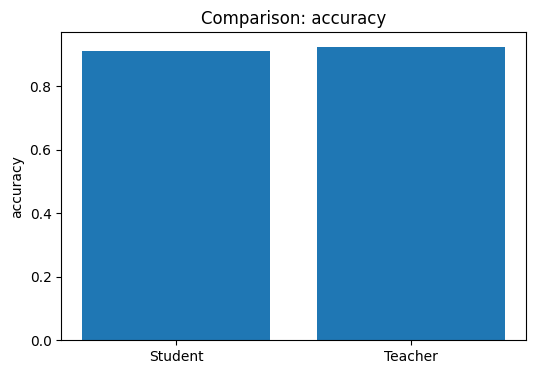

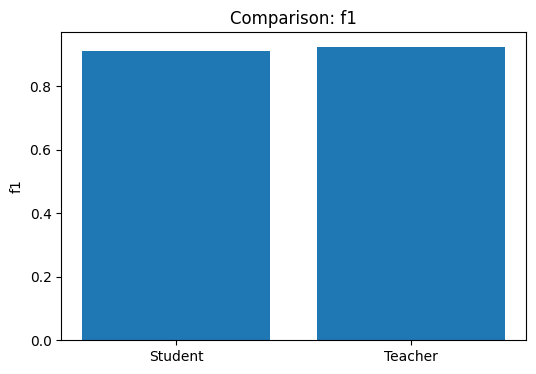

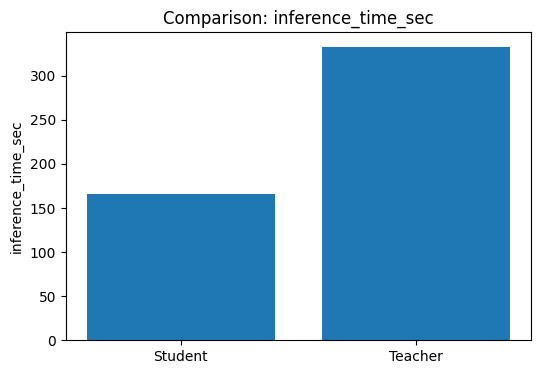

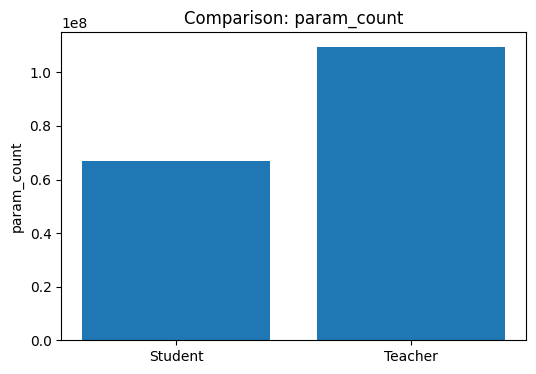

In [ ]:
import matplotlib.pyplot as plt
import os


plots_dir = "/content/drive/MyDrive/CS4782FinalProject/artifacts/imdb/plots"
os.makedirs(plots_dir, exist_ok=True)


metrics = ["accuracy", "f1", "inference_time_sec", "param_count"]

for metric in metrics:
    plt.figure(figsize=(6, 4))
    plt.bar(comparison_df["Model"], comparison_df[metric])
    plt.title(f"Comparison: {metric}")
    plt.ylabel(metric)
    plt.show()

    save_path = os.path.join(plots_dir, f"{metric}_comparison.png")
    plt.savefig(save_path)

    plt.close()

In [ ]:
print(student_results)
print(teacher_results)

{'accuracy': 0.91024, 'precision': 0.9045440201956453, 'recall': 0.91728, 'f1': 0.9108674928503336, 'confusion_matrix': array([[11290,  1210],
       [ 1034, 11466]]), 'inference_time_sec': 166.29263401031494, 'param_count': 66955010}
{'accuracy': 0.92436, 'precision': 0.9233777635884748, 'recall': 0.92552, 'f1': 0.9244476407367453, 'confusion_matrix': array([[11540,   960],
       [  931, 11569]]), 'inference_time_sec': 332.6250550746918, 'param_count': 109483778}


# **Finetuning for CoLa dataset**


In [ ]:
dataset = load_dataset("glue", "cola")


NameError: name 'load_dataset' is not defined